# 1.11 Narcissism, Perfectionism and A/B Testing

In [1]:
from datascience import *
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

from scipy import stats

I keep some data frames in CSV format accessible from my website. One of them is called `personality.csv` and has, as you might imagine, personality variables. In this case, we are using a subset of the personality data with variables like perfectionsism, narcissism with grouping variables like biological sex and the `AccDate` variable which has Yes/No responses to the following question:

"At a time in your life when you are not involved with anyone, a person asks you out. This person has a great personality, but you do not find this person physically attractive. Do you accept the date?"

In [2]:
pers = Table.read_table('http://faculty.ung.edu/rsinn/perfnarc.csv')
pers.num_rows

148

In [3]:
pers.labels

('Sex', 'G21', 'Greek', 'AccDate', 'Stress1', 'Stress2', 'Perf', 'Narc')

In [4]:
pers

Sex,G21,Greek,AccDate,Stress1,Stress2,Perf,Narc
F,N,N,N,9,7,99,3
F,Y,N,Y,11,13,86,2
F,N,Y,N,15,14,118,4
F,N,N,Y,16,15,113,2
F,Y,N,Y,17,17,107,8
F,N,N,N,10,7,123,1
F,N,N,N,16,18,93,4
F,N,Y,Y,12,12,126,7
F,N,N,Y,11,16,91,5
F,Y,N,Y,18,16,111,1


In [5]:
narc = pers.select('Sex','Narc')

The `nan` value indicates there is no value for that cell in the table. In this case, it's a survey item that went unanswered. The `numpy` function `nanmean` takes the average but ignores any `nan` values. In a clean table, we could just use `np.mean`, instead.

In [6]:
narc.group('Sex', np.average)

Sex,Narc average
F,3.81176
M,5.57143


In [7]:
a_mean = narc.group(0,np.average).column(1).item(0)
a_mean

3.8117647058823527

In [8]:
b_mean = narc.group(0,np.average).column(1).item(1)
b_mean

5.571428571428571

In [9]:
observed_difference = a_mean - b_mean
observed_difference

-1.7596638655462185

C:\Users\robbs\anaconda3\envs\datasci\lib\site-packages\datascience\tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array(tuple(values))


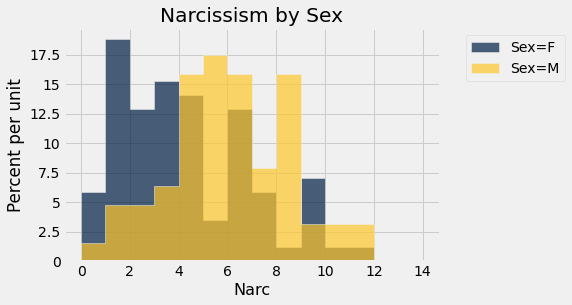

In [10]:
integer_bins = np.arange(15)
narc.hist('Narc', group = "Sex", bins = integer_bins)
_=plots.title('Narcissism by Sex')

## An A/B Test for differences in narcissism based on biological sex.

Notice that we simplify to the `narc` table which has only two columns, a grouping variable (Male/Female) and a numeric variable (narcissism score).

In [11]:
narc

Sex,Narc
F,3
F,2
F,4
F,2
F,8
F,1
F,4
F,7
F,5
F,1


## Let's shuffle the labels in the grouping variable column

In [12]:
shuffle_sex = narc.sample(with_replacement = False).column(0)
shuffle_sex

array(['F', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'M', 'M', 'F', 'M', 'M', 'F', 'F', 'F', 'F', 'M',
       'M', 'M', 'F', 'M', 'M', 'F', 'M', 'F', 'F', 'F', 'F', 'M', 'F',
       'M', 'F', 'M', 'F', 'M', 'F', 'M', 'M', 'F', 'F', 'M', 'M', 'F',
       'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'F', 'M', 'F', 'F', 'F',
       'M', 'M', 'F', 'M', 'M', 'F', 'F', 'F', 'F', 'M', 'F', 'M', 'F',
       'F', 'F', 'F', 'M', 'F', 'M', 'F', 'F', 'F', 'F', 'M', 'F', 'F',
       'F', 'M', 'F', 'M', 'M', 'M', 'M', 'F', 'M', 'F', 'F', 'F', 'M',
       'F', 'M', 'F', 'M', 'F', 'M', 'M', 'F', 'F', 'M', 'F', 'F', 'F',
       'F', 'F', 'M', 'M', 'F', 'F', 'F', 'M', 'F', 'M', 'F', 'F', 'M',
       'M', 'F', 'F', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'F', 'F', 'F',
       'F', 'F', 'M', 'F', 'F'], dtype='<U1')

In [13]:
shuffled_narc = narc.with_column("Shuffled Grouping",shuffle_sex).select(2,1)
shuffled_narc

Shuffled Grouping,Narc
F,3
F,2
F,4
M,2
F,8
F,1
M,4
M,7
F,5
F,1


In [14]:
shuffled_narc.group('Shuffled Grouping',np.average)

Shuffled Grouping,Narc average
F,4.27059
M,4.95238


### Create a function that produces a random shuffle of the grouping variable column

We're copy-pasting the code from the previous 3-4 code blocks to make our function, and using the generic name `tab` for our data table.

In [15]:
def ab_shuffle(tab):
    shuffle_group = tab.sample(with_replacement = False).column(0)
    shuffled_tab = tab.with_column("Shuffled Grouping",shuffle_group).select(2,1)
    return shuffled_tab

ab_shuffle(narc)

Shuffled Grouping,Narc
M,3
M,2
M,4
F,2
F,8
M,1
F,4
F,7
F,5
F,1


### Function that calculates difference in means between shuffled A/B groups

From above, we were using the `.group` method to find our group means.

In [16]:
shuffled_narc.group('Shuffled Grouping',np.average)

Shuffled Grouping,Narc average
F,4.27059
M,4.95238


In [17]:
a_mean = shuffled_narc.group('Shuffled Grouping',np.average).column(1).item(0)
a_mean

4.270588235294118

In [18]:
b_mean = shuffled_narc.group('Shuffled Grouping',np.average).column(1).item(1)
b_mean

4.9523809523809526

In [19]:
diff = a_mean - b_mean
diff

-0.681792717086835

We can see that we need to accept a generic two-column table where the grouping variable is listed first. Then we can use the above 3-4 to create our function.

In [20]:
def ab_diff(tab):
    tab.group(0,np.average)
    a_mean = tab.group(0,np.average).column(1).item(0)
    b_mean = tab.group(0,np.average).column(1).item(1)
    return a_mean - b_mean

ab_diff(shuffled_narc)

-0.681792717086835

### Run simulation lots of times

In [21]:
diffs = make_array()

reps = 1000

for i in range(reps):
    shuffled_tab = ab_shuffle(narc)
    new_diff = ab_diff(shuffled_tab)
    diffs = np.append(diffs, new_diff)
    
# diffs

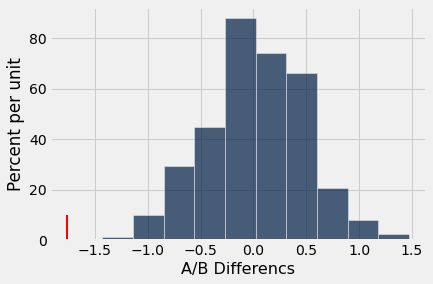

In [22]:
def ab_hist(myArray, obs_diff):
    tab = Table().with_column('A/B Differencs',myArray)
    tab.hist(0)
    _ = plots.plot([obs_diff, obs_diff], [0, 0.1], color='red', lw=2)

ab_hist(diffs,observed_difference)

Create a truth array for the number of randomized A/B differences in means that were less than the `observed_difference`

In [23]:
sum(diffs <= observed_difference)

0

In [24]:
p_val = sum(diffs <= observed_difference) / reps
p_val

0.0

## Example with perfectionism

In [25]:
perf = pers.select('Sex','Perf')
perf

Sex,Perf
F,99
F,86
F,118
F,113
F,107
F,123
F,93
F,126
F,91
F,111


In [26]:
obs_diff_perf = ab_diff(perf)
obs_diff_perf

2.5915966386554743

In [27]:
ab_shuffle(perf)

Shuffled Grouping,Perf
M,99
F,86
F,118
F,113
F,107
F,123
M,93
F,126
M,91
F,111


In [28]:
ab_diff(ab_shuffle(perf))

2.315219421101773

In [29]:
perf_diffs = make_array()

reps = 1000

for i in range(reps):
    new_diff = ab_diff(ab_shuffle(perf))
    perf_diffs = np.append(perf_diffs, new_diff)

# perf_diffs    

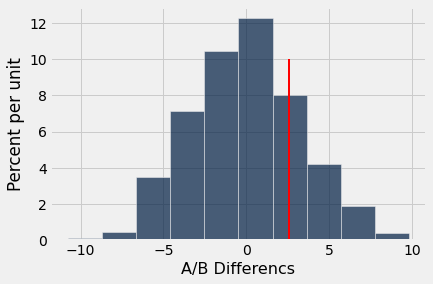

In [30]:
ab_hist(perf_diffs,obs_diff_perf)

In [31]:
p_value = sum(perf_diffs >= obs_diff_perf) / reps 
p_value

0.203